In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import time
import os

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix

In [26]:
TRAIN_PATIENTS = ['100', '101', '102', '103', '104']
#TRAIN_PATIENTS = ['100', '101', '102']
TEST_PATIENTS = ['106', '119']

SAMPLES_BEFORE = 30
SAMPLES_AFTER = 60
WINDOW_SIZE = SAMPLES_BEFORE + SAMPLES_AFTER

# Cechy PCA - tyle kubitów
N_DIM = 8
LIMIT_PER_PATIENT = 600

NORMAL_SYMBOLS = ['N', 'L', 'R', 'e', 'j']
ANOMALY_SYMBOLS = ['V', 'A', 'a', 'J', 'S', 'F', '!', 'E', '/']

In [27]:
def load_patient_data(patiend_id):
    # Wczytuje sygnał i wycina uderzenia na podstawie adnotacji
    ekg_file = f'archive/{patiend_id}_ekg.csv'
    ann_file = f'archive/{patiend_id}_annotations_1.csv'
    
    if not os.path.exists(ekg_file) or not os.path.exists(ann_file):
        print('nie ma pliku')
        return [], []
    
    # wczytywanie sygnału ekg dla pacjenta, szukam po tej kolumnie MLII
    df_ekg = pd.read_csv(ekg_file)
    # Usuwamy spacje z nazw kolumn (częsty błąd w CSV)
    df_ekg.columns = df_ekg.columns.str.strip()
    
    try:
        if 'MLII' in df_ekg.columns:
                signal = df_ekg['MLII'].values
        elif 'V5' in df_ekg.columns:
            signal = df_ekg['V5'].values
        else:
            # Jeśli nie ma nazw, bierzemy kolumnę indeks 1 (bo 0 to zazwyczaj czas/sample)
            signal = df_ekg.iloc[:, 1].values
    except Exception as e:
        print(f'error {e}')
        return [], []
    
    den = np.max(signal) - np.min(signal)
    if den == 0:
        return [], []
    signal = (signal - np.min(signal)) / den
    
    try:
        df_ann = pd.read_csv(ann_file)
        df_ann.columns = df_ann.columns.str.strip() # Czyścimy nazwy
            
        # Szukamy odpowiednich kolumn (sample = pozycja, symbol = typ)
        # Czasami nazywają się 'sample', 'Sample', 'time', etc.
        sample_col = next((c for c in df_ann.columns if 'index' in c.lower()), None)
        symbol_col = next((c for c in df_ann.columns if 'annotation_symbol' in c.lower()), None)
        
        if not sample_col or not symbol_col:
            print("  Nie znaleziono kolumn 'sample' lub 'symbol' w adnotacjach.")
            return [], []
        
        peaks = df_ann[sample_col].values
        symbols = df_ann[symbol_col].values
    except Exception as e:
        print(f'blad {e}')
        return [], []
    
    beats_normal = []
    beats_anomaly = []
    
    for p, sym in zip(peaks, symbols):
        # Pomijamy uderzenia na samym początku lub końcu nagrania
        if p - SAMPLES_BEFORE < 0 or p + SAMPLES_AFTER > len(signal):
            continue
            
        # Wycinek
        window = signal[p - SAMPLES_BEFORE : p + SAMPLES_AFTER]
        
        # Upewniamy się, że długość jest idealna
        if len(window) != WINDOW_SIZE:
            continue

        # Klasyfikacja
        if sym in NORMAL_SYMBOLS:
            if len(beats_normal) < LIMIT_PER_PATIENT:
                beats_normal.append(window)
        elif sym in ANOMALY_SYMBOLS:
            if len(beats_anomaly) < LIMIT_PER_PATIENT:
                beats_anomaly.append(window)
                
    print(f"  -> Znaleziono: {len(beats_normal)} Normal, {len(beats_anomaly)} Anomaly")
    return beats_normal, beats_anomaly

>>> KROK 1: Wczytywanie danych treningowych (Zdrowi)...
  -> Znaleziono: 600 Normal, 34 Anomaly
  -> Znaleziono: 600 Normal, 3 Anomaly
  -> Znaleziono: 99 Normal, 600 Anomaly
  -> Znaleziono: 600 Normal, 2 Anomaly
  -> Znaleziono: 163 Normal, 600 Anomaly

>>> KROK 2: Wczytywanie danych testowych (Mieszane)...
  -> Znaleziono: 600 Normal, 520 Anomaly
  -> Znaleziono: 600 Normal, 444 Anomaly

STATUS DANYCH SUROWYCH:
Wymiar pojedynczego uderzenia: 90 próbek
Liczba próbek Train (Normal): 2062
Liczba próbek Test (Normal): 1200
Liczba próbek Test (Anomaly): 964

>>> KROK 3: Redukcja wymiaru (PCA) z 90 do 8...
Wyjaśniona wariancja (ile info zachowaliśmy): 99.73%
>>> KROK 4: Skalowanie do zakresu (0, pi)...
Zapisano PCA i scaler do pliku: preprocessing_8dim.joblib

>>> KROK 5: Zapisywanie plików .npy...
GOTOWE! Możesz teraz uruchomić skrypt z Qiskit.

>>> Generowanie wykresu kontrolnego...


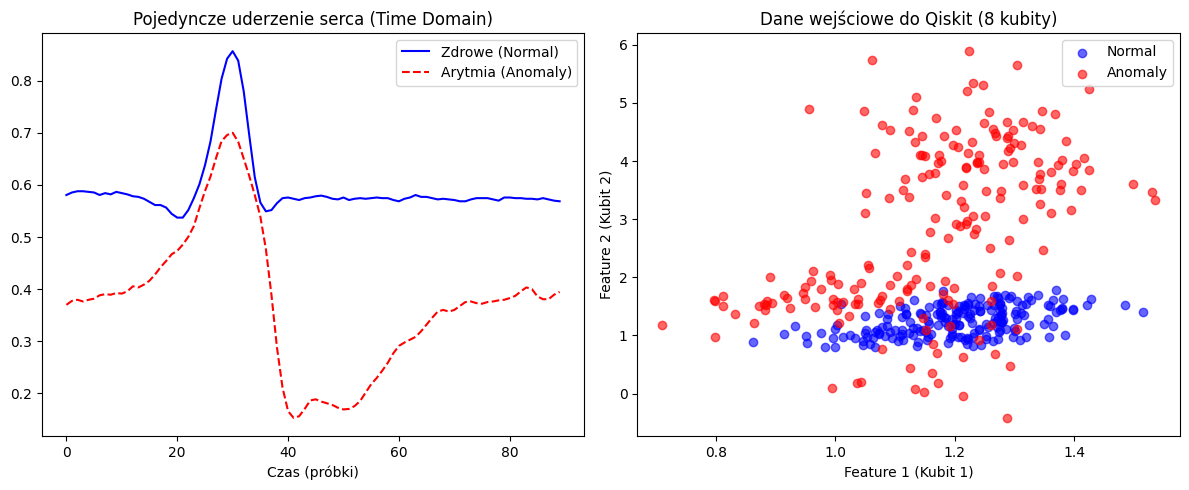

In [28]:
# --- ZBIERANIE DANYCH ---
all_train_normal = []
all_test_normal = []
all_test_anomaly = []

print(">>> KROK 1: Wczytywanie danych treningowych (Zdrowi)...")
for pid in TRAIN_PATIENTS:
    n, _ = load_patient_data(pid)
    all_train_normal.extend(n)

print("\n>>> KROK 2: Wczytywanie danych testowych (Mieszane)...")
for pid in TEST_PATIENTS:
    n, a = load_patient_data(pid)
    all_test_normal.extend(n)
    all_test_anomaly.extend(a)

# Konwersja na numpy array
X_train = np.array(all_train_normal)
X_test_normal = np.array(all_test_normal)
X_test_anomaly = np.array(all_test_anomaly)

print(f"\nSTATUS DANYCH SUROWYCH:")
print(f"Wymiar pojedynczego uderzenia: {WINDOW_SIZE} próbek")
print(f"Liczba próbek Train (Normal): {X_train.shape[0]}")
print(f"Liczba próbek Test (Normal): {X_test_normal.shape[0]}")
print(f"Liczba próbek Test (Anomaly): {X_test_anomaly.shape[0]}")

if len(X_train) == 0:
    print("BŁĄD KRYTYCZNY: Brak danych treningowych. Sprawdź nazwy plików CSV!")
    raise ValueError

# --- PRZETWARZANIE (PCA) ---
print(f"\n>>> KROK 3: Redukcja wymiaru (PCA) z {WINDOW_SIZE} do {N_DIM}...")

# 1. Trenujemy PCA tylko na zdrowych danych treningowych
pca = PCA(n_components=N_DIM)
pca.fit(X_train)

# 2. Transformujemy wszystkie zbiory
X_train_pca = pca.transform(X_train)
X_test_normal_pca = pca.transform(X_test_normal)

# Obsługa przypadku, gdyby nie było anomalii (żeby kod nie padł)
if len(X_test_anomaly) > 0:
    X_test_anomaly_pca = pca.transform(X_test_anomaly)
else:
    X_test_anomaly_pca = np.empty((0, N_DIM))

print(f"Wyjaśniona wariancja (ile info zachowaliśmy): {sum(pca.explained_variance_ratio_):.2%}")

# --- SKALOWANIE DO KOMPUTERA KWANTOWEGO ---
# Qiskit lubi dane w zakresie (0, pi) lub (-1, 1). 
# Użyjemy (0, pi) pod bramki rotacji.
print(">>> KROK 4: Skalowanie do zakresu (0, pi)...")

scaler = MinMaxScaler(feature_range=(0, np.pi))
scaler.fit(X_train_pca) # Uczymy skaler na treningu

joblib.dump(
    {
    "pca": pca,
    "scaler": scaler,
    "n_dim": N_DIM,
    "window_size": WINDOW_SIZE
    },
    "ibm_preprocessing_8dim.joblib"
)
print("Zapisano PCA i scaler do pliku: preprocessing_8dim.joblib")

X_train_final = scaler.transform(X_train_pca)
X_test_normal_final = scaler.transform(X_test_normal_pca)

if len(X_test_anomaly) > 0:
    X_test_anomaly_final = scaler.transform(X_test_anomaly_pca)
else:
    X_test_anomaly_final = X_test_anomaly_pca

# --- ZAPISYWANIE ---
print("\n>>> KROK 5: Zapisywanie plików .npy...")
np.save('train_data.npy', X_train_final)
np.save('test_normal.npy', X_test_normal_final)
np.save('test_anomaly.npy', X_test_anomaly_final)
print("GOTOWE! Możesz teraz uruchomić skrypt z Qiskit.")

# --- WIZUALIZACJA ---
print("\n>>> Generowanie wykresu kontrolnego...")
plt.figure(figsize=(12, 5))

# Wykres 1: Jak wygląda surowe uderzenie?
plt.subplot(1, 2, 1)
plt.plot(X_train[0], label='Zdrowe (Normal)', color='blue')
if len(X_test_anomaly) > 0:
    plt.plot(X_test_anomaly[0], label='Arytmia (Anomaly)', color='red', linestyle='--')
plt.title("Pojedyncze uderzenie serca (Time Domain)")
plt.xlabel("Czas (próbki)")
plt.legend()

# Wykres 2: Jak to wygląda po PCA?
plt.subplot(1, 2, 2)
# Rysujemy tylko po 100 kropek żeby było czytelnie
plt.scatter(X_test_normal_final[:200, 0], X_test_normal_final[:200, 1], 
            c='blue', alpha=0.6, label='Normal')
if len(X_test_anomaly_final) > 0:
    plt.scatter(X_test_anomaly_final[:200, 0], X_test_anomaly_final[:200, 1], 
                c='red', alpha=0.6, label='Anomaly')
plt.title(f"Dane wejściowe do Qiskit ({N_DIM} kubity)")
plt.xlabel("Feature 1 (Kubit 1)")
plt.ylabel("Feature 2 (Kubit 2)")
plt.legend()

plt.tight_layout()
plt.show()

>>> START: KLASYCZNY AUTOENKODER (Input: 8 -> Hidden: 4 -> Output: 8)
    Trening na: 600 próbkach
    Dane treningowe: (600, 8)
>>> Trenowanie sieci neuronowej...
    Trening zakończony.
    Końcowy Loss: 0.033613


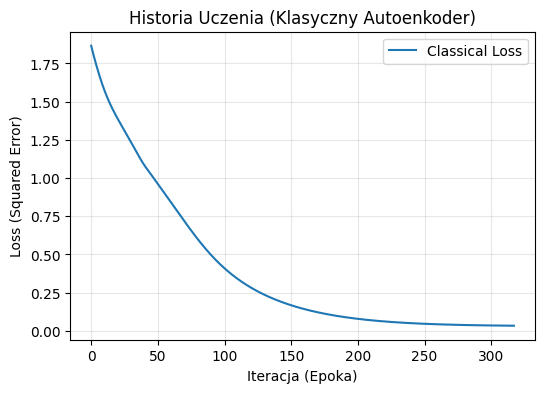

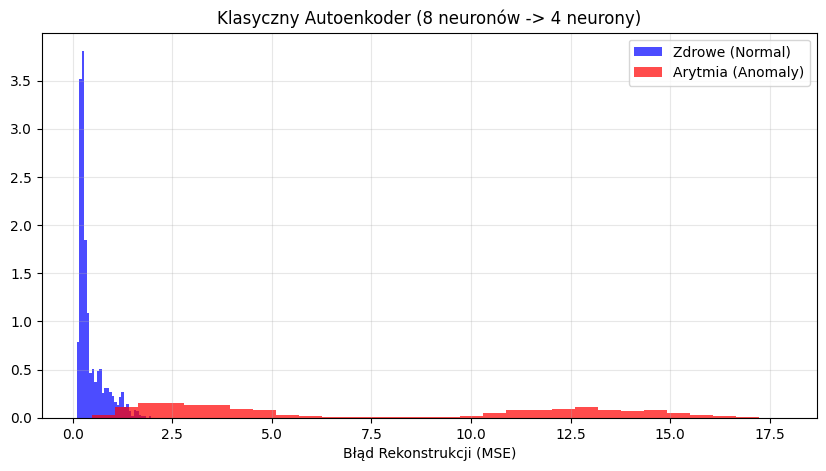


>>> Wyznaczony próg odcięcia (Threshold): 4.0017
>>> WYNIKI KOŃCOWE (KLASYCZNE):
    Dokładność (Accuracy): 81.56%


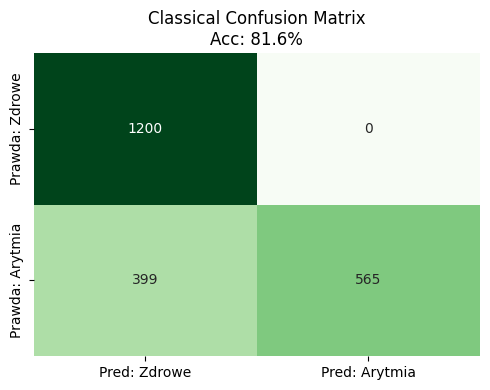

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import accuracy_score, confusion_matrix

# --- KONFIGURACJA (Taka sama jak w Quantum) ---
INPUT_DIM = 8       # Odpowiednik 8 kubitów
HIDDEN_DIM = 4      # Odpowiednik kompresji
LIMIT_SAMPLES = 600 # Zmień na 100, 300, 600 w kolejnych testach

print(f">>> START: KLASYCZNY AUTOENKODER (Input: {INPUT_DIM} -> Hidden: {HIDDEN_DIM} -> Output: {INPUT_DIM})")

# 1. Wczytanie danych
try:
    train_data = np.load('train_data.npy')[:LIMIT_SAMPLES]
    test_normal = np.load('test_normal.npy')
    test_anomaly = np.load('test_anomaly.npy')
except FileNotFoundError:
    print("BŁĄD: Brak plików .npy! Uruchom prepare_data.py")
    exit()

print(f"    Trening na: {len(train_data)} próbkach")
print(f"    Dane treningowe: {train_data.shape}")

# 2. Model Klasyczny (MLP)
# Architektura: Wejście(8) -> Ukryta(4) -> Wyjście(8)
# activation='tanh' jest najbardziej zbliżona do bramek kwantowych (zakres -1 do 1)
# solver='adam' to ten sam optimizer co w lepszych sieciach
autoencoder = MLPRegressor(
    hidden_layer_sizes=(HIDDEN_DIM,), 
    activation='tanh', 
    solver='adam', 
    max_iter=1000, 
    random_state=42
)

# 3. Trening (X -> X)
# W autoenkoderze wejście (X) jest też celem (Y). Sieć ma odtworzyć to, co dostała.
print(">>> Trenowanie sieci neuronowej...")
autoencoder.fit(train_data, train_data)
print("    Trening zakończony.")
print(f"    Końcowy Loss: {autoencoder.loss_curve_[-1]:.6f}")

# WIZUALIZACJA PROCESU UCZENIA (LOSS)
plt.figure(figsize=(6, 4))
plt.plot(autoencoder.loss_curve_, label='Classical Loss')
plt.title("Historia Uczenia (Klasyczny Autoenkoder)")
plt.xlabel("Iteracja (Epoka)")
plt.ylabel("Loss (Squared Error)")
plt.grid(alpha=0.3)
plt.legend()
plt.savefig(f"classical_loss_{LIMIT_SAMPLES}.png")

# 4. Ewaluacja (Liczymy błąd rekonstrukcji: MSE)
def get_reconstruction_error(data):
    predictions = autoencoder.predict(data)
    # Błąd to średnia kwadratów różnic między wejściem a wyjściem
    mse = np.mean(np.power(data - predictions, 2), axis=1)
    return mse

mse_normal = get_reconstruction_error(test_normal)
mse_anomaly = get_reconstruction_error(test_anomaly)

# 5. Wizualizacja Histogramu (Porównaj to z wykresem z IBM!)
plt.figure(figsize=(10, 5))
plt.hist(mse_normal, bins=30, alpha=0.7, color='blue', label='Zdrowe (Normal)', density=True)
plt.hist(mse_anomaly, bins=30, alpha=0.7, color='red', label='Arytmia (Anomaly)', density=True)
plt.title(f"Klasyczny Autoenkoder (8 neuronów -> 4 neurony)")
plt.xlabel("Błąd Rekonstrukcji (MSE)")
plt.legend()
plt.grid(alpha=0.3)
plt.savefig("classical_histogram.png")
plt.show()

# ==========================================
# 6. OBLICZANIE ACCURACY (Klasyfikacja)
# ==========================================
# Musimy znaleźć próg (Threshold), który najlepiej oddziela górki
# W klasyce ZAZWYCZAJ arytmia ma WIĘKSZY błąd (po prawej)

# Automatyczne szukanie progu (średnia między średnimi obu rozkładów)
threshold = (np.mean(mse_normal) + np.mean(mse_anomaly)) / 2
print(f"\n>>> Wyznaczony próg odcięcia (Threshold): {threshold:.4f}")

# Klasyfikacja:
# 0 = Zdrowe (Błąd < Threshold)
# 1 = Arytmia (Błąd > Threshold)
# UWAGA: Tutaj logika jest "normalna" (duży błąd = choroba). 
# W kwantowym miałeś "inwersję". Tutaj pewnie jej nie będzie.

y_pred_norm = [1 if e > threshold else 0 for e in mse_normal]
y_pred_anom = [1 if e > threshold else 0 for e in mse_anomaly]

y_true = [0] * len(mse_normal) + [1] * len(mse_anomaly)
y_pred = y_pred_norm + y_pred_anom

acc = accuracy_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)

print(f">>> WYNIKI KOŃCOWE (KLASYCZNE):")
print(f"    Dokładność (Accuracy): {acc:.2%}")

# Macierz Pomyłek
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False,
            xticklabels=['Pred: Zdrowe', 'Pred: Arytmia'],
            yticklabels=['Prawda: Zdrowe', 'Prawda: Arytmia'])
plt.title(f'Classical Confusion Matrix\nAcc: {acc:.1%}')
plt.tight_layout()
plt.savefig("classical_confusion_matrix.png")
plt.show()

>>> AUC (Pole pod krzywą): 0.9957


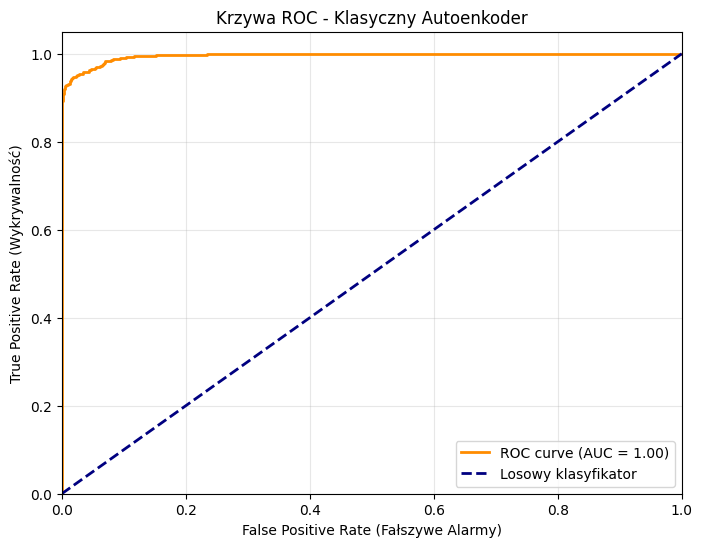

In [30]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Przygotowanie Danych do ROC ---
# Musimy połączyć wyniki w jeden długi wektor
y_scores = np.concatenate([mse_normal, mse_anomaly])

# Musimy stworzyć wektor prawdziwych etykiet (0 = Zdrowe, 1 = Arytmia)
y_true = np.concatenate([np.zeros(len(mse_normal)), np.ones(len(mse_anomaly))])

# --- 2. Obliczenie Krzywej ROC ---
# Funkcja zwraca:
# fpr = False Positive Rate (Ile razy fałszywie wszczęliśmy alarm)
# tpr = True Positive Rate (Ile razy poprawnie wykryliśmy chorobę)
fpr, tpr, thresholds = roc_curve(y_true, y_scores)

# --- 3. Obliczenie AUC (Area Under Curve) ---
# To jest ta jedna liczba, którą wpisujesz do tabelki (np. 0.95)
roc_auc = auc(fpr, tpr)
print(f">>> AUC (Pole pod krzywą): {roc_auc:.4f}")

# --- 4. Rysowanie Wykresu ---
plt.figure(figsize=(8, 6))

# Rysujemy krzywą modelu
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')

# Rysujemy linię losowego zgadywania (przekątna)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Losowy klasyfikator')

# Upiększanie
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (Fałszywe Alarmy)')
plt.ylabel('True Positive Rate (Wykrywalność)')
plt.title('Krzywa ROC - Klasyczny Autoenkoder')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)

plt.savefig("classical_roc_curve.png")
plt.show()

In [31]:
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import accuracy_score, roc_auc_score, mean_squared_error

# --- KONFIGURACJA ---
ALL_AVAILABLE_PATIENTS = ['100', '101', '102', '103', '104']
Jakie konfiguracje pacjentów testujemy?
# 1 = ['100']
# 2 = ['100', '101']
# 3 = ['100', '101', '102']
# 5 = ['100', '101', '102', '103', '104']
PATIENT_COUNTS_TO_TEST = [1, 2, 3, 5]

LIMITS_PER_PATIENT = [100, 200, 400, 600]  # Odpowiada ['100'], ['100','101'], ['100','101','102']
HIDDEN_DIMS = [4, 8] # Badanie wielkości warstwy ukrytej
MAX_CHUNK_SIZE = 600

print(f">>> 1. Ładowanie danych (Oczekuję {len(ALL_AVAILABLE_PATIENTS)} pacjentów w pliku)...")
try:
    full_train_data = np.load('train_data.npy')
    test_normal = np.load('test_normal.npy')
    test_anomaly = np.load('test_anomaly.npy')
except FileNotFoundError:
    print("BŁĄD: Brak plików danych! Uruchom prepare_data.py z 5 pacjentami.")
    exit()

# Sprawdzenie czy plik jest wystarczająco duży
expected_min_size = len(ALL_AVAILABLE_PATIENTS) * MAX_CHUNK_SIZE
if len(full_train_data) < expected_min_size:
    print(f"OSTRZEŻENIE: Plik train_data.npy ma {len(full_train_data)} próbek.")
    print(f"A potrzebujemy {expected_min_size} (5 pacjentów * 600).")
    print("Czy na pewno uruchomiłeś prepare_data.py z listą ['100'...'104']?")
    # exit() # Odkomentuj, jeśli chcesz wymusić stop

results_table = []

print("\n>>> 2. Rozpoczynam Grid Search (To chwilę potrwa)...")

for h_dim in HIDDEN_DIMS:
    for n_patients in PATIENT_COUNTS_TO_TEST:
        
        # Generujemy nazwę grupy pacjentów (np. "['100', '101']")
        current_patients_ids = ALL_AVAILABLE_PATIENTS[:n_patients]
        
        for limit in LIMITS_PER_PATIENT:
            
            # --- PRZYGOTOWANIE DANYCH (Slicing) ---
            batch_parts = []
            
            # Pętla po konkretnych pacjentach w tej konfiguracji
            for i in range(n_patients):
                # Obliczamy gdzie w dużym pliku zaczyna się i kończy dany pacjent
                # Pacjent 0: 0-600, Pacjent 1: 600-1200 itd.
                start_in_file = i * MAX_CHUNK_SIZE
                end_in_file = start_in_file + limit # Bierzemy tylko 'limit' próbek
                
                # Zabezpieczenie
                if start_in_file >= len(full_train_data):
                    break
                    
                chunk = full_train_data[start_in_file : end_in_file]
                batch_parts.append(chunk)
            
            if not batch_parts:
                continue
                
            current_train_data = np.concatenate(batch_parts)
            total_samples = len(current_train_data)
            
            # Logowanie postępu
            print(f" -> H={h_dim} | Pacjenci={n_patients} {current_patients_ids} | Limit={limit} (Suma: {total_samples})")

            # --- TRENING ---
            model = MLPRegressor(
                hidden_layer_sizes=(h_dim,),
                activation='tanh',
                solver='adam',
                max_iter=1000,
                random_state=42 # Stałe ziarno dla porównywalności
            )
            
            model.fit(current_train_data, current_train_data)
            
            # --- WYNIKI ---
            final_loss = model.loss_curve_[-1]
            
            # MSE
            pred_norm = model.predict(test_normal)
            mse_norm = np.mean(np.power(test_normal - pred_norm, 2), axis=1)
            
            pred_anom = model.predict(test_anomaly)
            mse_anom = np.mean(np.power(test_anomaly - pred_anom, 2), axis=1)
            
            # ROC AUC
            y_scores = np.concatenate([mse_norm, mse_anom])
            y_true = [0] * len(mse_norm) + [1] * len(mse_anom)
            
            try:
                auc_score = roc_auc_score(y_true, y_scores)
            except ValueError:
                auc_score = 0.5
            
            # Accuracy (automatyczny próg)
            threshold = (np.mean(mse_norm) + np.mean(mse_anom)) / 2
            y_pred = [1 if x > threshold else 0 for x in y_scores]
            acc_score = accuracy_score(y_true, y_pred)
            
            # Zapis rekordu
            results_table.append({
                "Hidden Dim": h_dim,
                "Liczba Pacjentów": n_patients,
                "ID Pacjentów": str(current_patients_ids),
                "Limit/Pacjent": limit,
                "Suma Próbek": total_samples,
                "Loss": round(final_loss, 6),
                "Accuracy (%)": round(acc_score * 100, 2),
                "ROC AUC": round(auc_score, 4)
            })

# --- ZAPIS ---
df = pd.DataFrame(results_table)
# Sortowanie: Najpierw Architektura, potem ilość pacjentów, potem limit
df = df.sort_values(by=["Hidden Dim", "Liczba Pacjentów", "Limit/Pacjent"])

print("\n" + "="*100)
print("WYNIKI KOŃCOWE - EFEKT SKALI I ARCHITEKTURY")
print("="*100)
print(df.to_string(index=False))

filename = "wyniki_eksperymentu_5_pacjentow.csv"
df.to_csv(filename, index=False)
print(f"\n>>> Zapisano do pliku: {filename}")

Object `testujemy` not found.
>>> 1. Ładowanie danych (Oczekuję 5 pacjentów w pliku)...
OSTRZEŻENIE: Plik train_data.npy ma 2062 próbek.
A potrzebujemy 3000 (5 pacjentów * 600).
Czy na pewno uruchomiłeś prepare_data.py z listą ['100'...'104']?

>>> 2. Rozpoczynam Grid Search (To chwilę potrwa)...
 -> H=4 | Pacjenci=1 ['100'] | Limit=100 (Suma: 100)
 -> H=4 | Pacjenci=1 ['100'] | Limit=200 (Suma: 200)
 -> H=4 | Pacjenci=1 ['100'] | Limit=400 (Suma: 400)
 -> H=4 | Pacjenci=1 ['100'] | Limit=600 (Suma: 600)
 -> H=4 | Pacjenci=2 ['100', '101'] | Limit=100 (Suma: 200)
 -> H=4 | Pacjenci=2 ['100', '101'] | Limit=200 (Suma: 400)
 -> H=4 | Pacjenci=2 ['100', '101'] | Limit=400 (Suma: 800)
 -> H=4 | Pacjenci=2 ['100', '101'] | Limit=600 (Suma: 1200)
 -> H=4 | Pacjenci=3 ['100', '101', '102'] | Limit=100 (Suma: 300)
 -> H=4 | Pacjenci=3 ['100', '101', '102'] | Limit=200 (Suma: 600)
 -> H=4 | Pacjenci=3 ['100', '101', '102'] | Limit=400 (Suma: 1200)
 -> H=4 | Pacjenci=3 ['100', '101', '102'] | Li

In [34]:
wyniki_tabelka = pd.read_csv('wyniki_eksperymentu_5_pacjentow.csv')
wyniki_tabelka.head(31)

,Hidden Dim,Liczba Pacjentów,ID Pacjentów,Limit/Pacjent,Suma Próbek,Loss,Accuracy (%),ROC AUC
0,4,1,['100'],100,100,0.038197,81.15,0.9945
1,4,1,['100'],200,200,0.038846,81.24,0.9946
2,4,1,['100'],400,400,0.033653,81.47,0.9955
3,4,1,['100'],600,600,0.033613,81.56,0.9957
4,4,2,"['100', '101']",100,200,0.043672,82.81,0.9910
5,4,2,"['100', '101']",200,400,0.046569,80.36,0.9917
6,4,2,"['100', '101']",400,800,0.047628,80.41,0.9945
7,4,2,"['100', '101']",600,1200,0.048084,80.64,0.9955
8,4,3,"['100', '101', '102']",100,300,0.074879,79.99,0.9694
9,4,3,"['100', '101', '102']",200,600,0.074402,80.22,0.9818
